In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import label_binarize
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('data-final-project-raw.csv')

In [3]:
#Preprocessing dan Analysis
df.head()

,nama_produk,harga,desc,terjual,total_rating,avg_rating,stock,os,kategori,store
0,Official Redmi A3 | Layar Muluz 90 Hz berukura...,Rp1.299.000,Desain Inovatif: Desain kamera deco yang memik...,Terjual 4 rb+,(1.956 rating),4.9,Stok: 274,Android OS,Handphone,Xiaomi Official Store
1,"vivo Y100 (8/256) - Magical Color Changing, 80...",Rp2.659.000,Y100 4G 8/256,Terjual 100+,(77 rating),4.9,Stok: 131,Android OS,Handphone,vivo Indonesia
2,TONER HP 87A BLACK ORIGINAL,Rp1.100.000,Toner Hp 87AHP LaserJet Black Toner Cartridge ...,No data available,No data available,No data available,Stok Total: 10000,Toner Printer,Printer,TUNAS-STATIONARY
3,HP Hot 40 Pro 16GB+512GB HD Handphone android ...,Rp880.000,✅ Produk memiliki masa garansi✅ Semua produk d...,Terjual 24,(17 rating),4.5,Stok: 497,Android OS,Handphone,hp reno11 pro
4,HP XIOMI REDMI NOTE 12 8/128GB // 8/256GB GARA...,Rp1.700.000,NETWORKTechnologyGSM / HSPA / LTEBODYDimension...,Terjual 5,(2 rating),5,Stok: Sisa 7,Android OS,Handphone,Gadget Store electronic


In [4]:
#Generalisasi atribut kategori
kelompok_kategori = {
    'Elektronik': ['Handphone', 'Printer', 'Tablet', 'Laptop', 'Desktop & Mini PC',
                   'PC & Laptop Gaming', 'Game Console', 'CD Game', 'Audio', 'TV & Aksesoris',
                   'Lampu', 'Wearable Devices', 'Aksesoris Game Console', 'Monitor'],
    'Lainnya': ['Vitamin & Suplemen', 'Grooming', 'Eyebrow Kit', 'Persiapan Pernikahan', 'Document Organizer',
                'Perlengkapan Medis', 'Frame, Album & Roll Film', 'Aksesoris Muslim', 'Penyimpanan Makanan',
                'Bridal', 'Perlengkapan Kebersihan'],
    'Gadget & Elektronik Musik': ['Game Console', 'Gitar & Bass'],
    'Perawatan Pribadi': ['Masker Kecantikan', 'Perawatan Wajah', 'Perawatan Rambut', 'Styling Rambut Wanita'],
    'Peralatan Rumah Tangga': ['Peralatan Makan & Minum', 'Tempat Penyimpanan', 'Peralatan Dapur', 'Aksesoris Dapur',
                               'Kebersihan', 'Ruang Tamu & Keluarga', 'Kamar Tidur', 'Kamar Mandi'],
    'Olahraga & Outdoor': ['Sepak Bola & Futsal', 'Aksesoris Olahraga', 'Basket', 'Boxing', 'Golf', 'Hiking & Camping',
                            'Pakaian Olahraga Pria', 'Pakaian Olahraga Wanita'],
    'Pakaian & Fashion': ['Pakaian Dalam Wanita', 'Aksesoris Pria', 'Aksesoris Wanita', 'Aksesoris Sepatu Wanita',
                          'Pakaian Anak Perempuan', 'Jeans & Denim Wanita', 'Sepatu Wanita', 'Bawahan Wanita',
                          'Dress Muslim Wanita', 'Sepatu Pria', 'Atasan Wanita', 'Outerwear Pria', 'Outerwear Wanita',
                          'Atasan Pria', 'Jeans & Denim Pria', 'Topi Pria', 'Pakaian Adat Wanita', 'Tas Wanita',
                          'Tas Anak'],
    'Kendaraan & Aksesori': ['Helm Motor', 'Spare Part Mobil', 'Interior Mobil'],
    'Makanan & Minuman': ['Mie & Pasta', 'Sayur', 'Makanan Jadi', 'Penyimpanan Makanan', 'Bekal'],
    'Perhiasan & Aksesori': ['Perhiasan Wanita', 'Aksesoris Rambut', 'Model Kit'],
    'Mainan & Anak-Anak': ['Mainan Anak - Anak', 'Perlengkapan Mandi Bayi', 'Tas Anak'],
}

def kelompokan_kategori_fn(kategori_item):
    for kelompok, items in kelompok_kategori.items():
        if kategori_item in items:
            return kelompok
    return 'Lainnya'

df['kategori'] = df['kategori'].apply(kelompokan_kategori_fn)

In [5]:
#Pergantian nama os menjadi sub_kategori
df = df.rename(columns={'os': 'sub_kategori'})

In [6]:
#Pembersihan data raw
df['harga'] = df['harga'].replace({'Rp': '', '\\.': ''}, regex=True).astype(int)
df['store'] = df['store'].replace('No data available', 'Official Store')
df['avg_rating'] = df['avg_rating'].replace('No data available', np.nan)

def extract_number(stok):
    if isinstance(stok, str):
        result = re.findall(r'\d+', stok)
        return int(result[0]) if result else None
    return np.nan

df['stock'] = df['stock'].apply(extract_number)
df['stock'] = df['stock'].astype('Int64')

def extract_rating(rating):
    result = re.findall(r'\d+\.?\d*', rating)
    if result:
        number = result[0].replace('.', '')
        return int(number)
    return np.nan

df['total_rating'] = df['total_rating'].apply(extract_rating)

def extract_terjual(terjual):
    result = re.findall(r'\d+', terjual)
    if result:
        number = int(result[0])
        if 'rb' in terjual:
            number *= 1000
        return number
    return np.nan

df['terjual'] = df['terjual'].apply(extract_terjual)

In [7]:
#Melabeli kategori dan sub_kategori menggunakan numerikal
label_encoder = LabelEncoder()
df['kategori_encoding'] = label_encoder.fit_transform(df['kategori']) + 1
df['sub_kategori_encoding'] = label_encoder.fit_transform(df['sub_kategori']) + 1

In [8]:
#Mengecek data NaN atau Null
print(df.isnull().sum())

nama_produk                0
harga                      0
desc                       0
terjual                  538
total_rating             551
avg_rating               551
stock                      5
sub_kategori               0
kategori                   0
store                      0
kategori_encoding          0
sub_kategori_encoding      0
dtype: int64


In [9]:
#Mengecek data deskriptif dari dataset
df.describe()

,harga,terjual,total_rating,stock,kategori_encoding,sub_kategori_encoding
count,1.172000e+03,634.000000,621.000000,1167.0,1172.000000,1172.000000
mean,1.704042e+06,840.011041,279.872786,999.87575,4.399317,71.213311
std,4.378985e+06,4711.732445,812.530765,8095.918749,3.540074,46.954333
min,1.000000e+02,1.000000,1.000000,1.0,1.000000,1.000000
25%,8.500000e+04,24.250000,11.000000,6.0,1.000000,24.000000
50%,2.399500e+05,100.000000,45.000000,23.0,4.000000,76.500000
75%,1.499900e+06,500.000000,169.000000,100.0,8.000000,113.000000
max,1.000000e+08,100000.000000,7194.000000,100000.0,11.000000,159.000000


In [10]:
#Pengisian data Nan
def fillDataNaN(row):
    if pd.isna(row):
        if np.random.rand() < 0.7:
            available_values = np.arange(1, 999)
        else:
            available_values = np.arange(1000, 10000)
        return np.random.choice(available_values)
    return row

df['terjual'] = df['terjual'].apply(fillDataNaN)

In [11]:
#Pengisian data Nan
def fillDataNaN(row):
    if pd.isna(row):
        available_values = np.arange(2.5, 3.9, 0.5)
        return np.random.choice(available_values)
    return row

df['avg_rating'] = pd.to_numeric(df['avg_rating'], errors='coerce')
df['avg_rating'] = df['avg_rating'].apply(fillDataNaN)

In [12]:
#Pengisian data Nan
def fillDataNaN(row):
    if pd.isna(row):
        if np.random.rand() < 0.2:
            available_values = np.arange(1000, 7194)
        else:
            available_values = np.arange(1, 999)
        return np.random.choice(available_values)
    return row

df['total_rating'] = df['total_rating'].apply(fillDataNaN)

In [13]:
#Pengisian data Nan
def fillDataNaN(row):
    if pd.isna(row):
        available_values = np.arange(1000, 5000)
        return np.random.choice(available_values)
    return row

df['stock'] = df['stock'].apply(fillDataNaN)

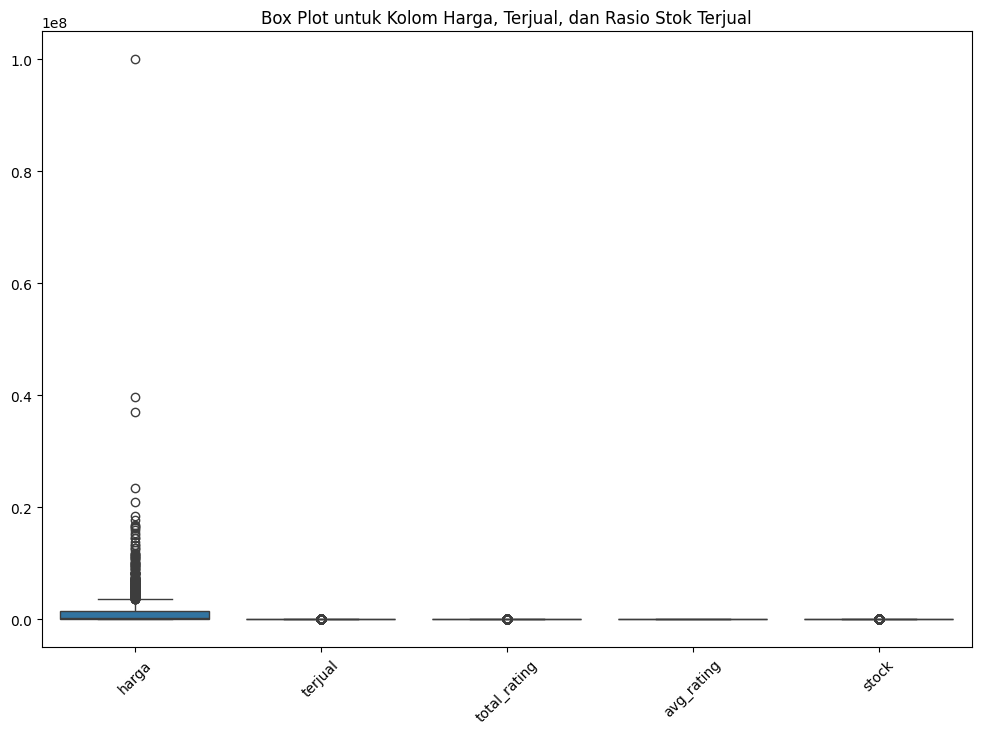

In [14]:
#Pengecekan Outlier
numerical_columns = ['harga', 'terjual', 'total_rating', 'avg_rating', 'stock']
plt.figure(figsize=(12, 8))

sns.boxplot(data=df[numerical_columns])
plt.title('Box Plot untuk Kolom Harga, Terjual, dan Rasio Stok Terjual')
plt.xticks(rotation=45)
plt.show()

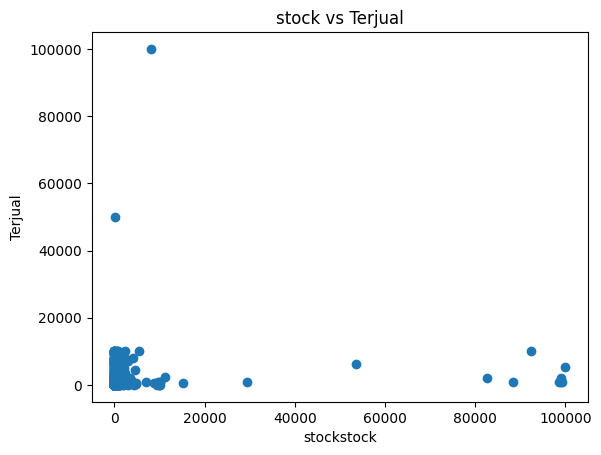

In [15]:
#Pengecekan Outlier
plt.scatter(df['stock'], df['terjual'])
plt.xlabel('stockstock')
plt.ylabel('Terjual')
plt.title('stock vs Terjual')
plt.show()

In [16]:
#Menghapusan Outlier
columns_to_check = ['terjual', 'total_rating', 'stock']

for column in columns_to_check:
    Q1 = df[column].quantile(0.15)
    Q3 = df[column].quantile(0.85)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df.describe()

,harga,terjual,total_rating,avg_rating,stock,kategori_encoding,sub_kategori_encoding
count,8.850000e+02,885.000000,885.000000,885.000000,885.000000,885.000000,885.000000
mean,1.805714e+06,518.187571,290.258757,4.161921,59.974011,4.091525,69.604520
std,4.713150e+06,855.111640,360.705386,0.985762,104.187323,3.443728,46.978063
min,1.100000e+03,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,9.700000e+04,40.000000,23.000000,3.000000,5.000000,1.000000,24.000000
50%,3.000000e+05,162.000000,123.000000,4.900000,18.000000,4.000000,74.000000
75%,1.700000e+06,718.000000,474.000000,5.000000,76.000000,8.000000,110.000000
max,1.000000e+08,5106.000000,2131.000000,5.000000,579.000000,11.000000,159.000000


In [17]:
#Penyimpanan cleaned dataset
df.to_csv('data-final-project-cleaned.csv', index=False)
df = pd.read_csv('data-final-project-cleaned.csv')

In [18]:
#Penambahan Atribut
df['harga_per_rating'] = df['harga'] / (df['total_rating'] + 1)
df['harga_terjual'] = df['harga'] * df['terjual']
df['skor_popularitas'] = (df['avg_rating'] * 0.4) + (df['terjual'] * 0.4) + (df['total_rating'] * 0.2)
df['avg_harga_per_kategori'] = df.groupby('kategori')['harga'].transform('mean')
df['stok_terjual_ratio'] = df['stock'] / (df['terjual'] + 1)
df['stok_ideal'] = df['stok_terjual_ratio'] * df['stock']
df['rasio_penjualan_stok'] = df['terjual'] / (df['stock'] + 1)
df['stok_ideal'] = np.ceil(df['stok_ideal'])
df['skor_popularitas'] = df['skor_popularitas'].round()

In [19]:
#Penambahan Atribut Class
def harga_kategori(row):
    if row["harga"] > 800000:
        return "Tinggi"
    elif 200000 <= row["harga"] <= 800000:
        return "Sedang"
    else:
        return "Rendah"

df["harga_kategori"] = df.apply(harga_kategori, axis=1)
df['harga_kategori_encoding'] = df['harga_kategori'].map({'Tinggi': 2, 'Sedang': 1, 'Rendah': 0})
df["harga_kategori"].value_counts()

df['restock'] = df.apply(
    lambda x: 'Restock' if x['stok_ideal'] / x['stock'] < 1
    else ('Tidak Restock' if x['stok_ideal'] / x['stock'] == 1
    else 'Stok Berlebih'), axis=1)

df['restock_encoding'] = df['restock'].map({'Restock': 2,'Tidak Restock' : 1, 'Stok Berlebih': 0})
df['restock'].value_counts()

df['popularitas'] = df['skor_popularitas'].apply(
    lambda x: 'Sangat Populer' if x > 4 else ('Populer' if x > 3 else 'Tidak Populer')
)
df['popularitas_encoding'] = df['popularitas'].map({'Sangat Populer': 2, 'Populer': 1, 'Tidak Populer': 0})
df['popularitas'].value_counts()

,count
popularitas,
Sangat Populer,842
Tidak Populer,23
Populer,20


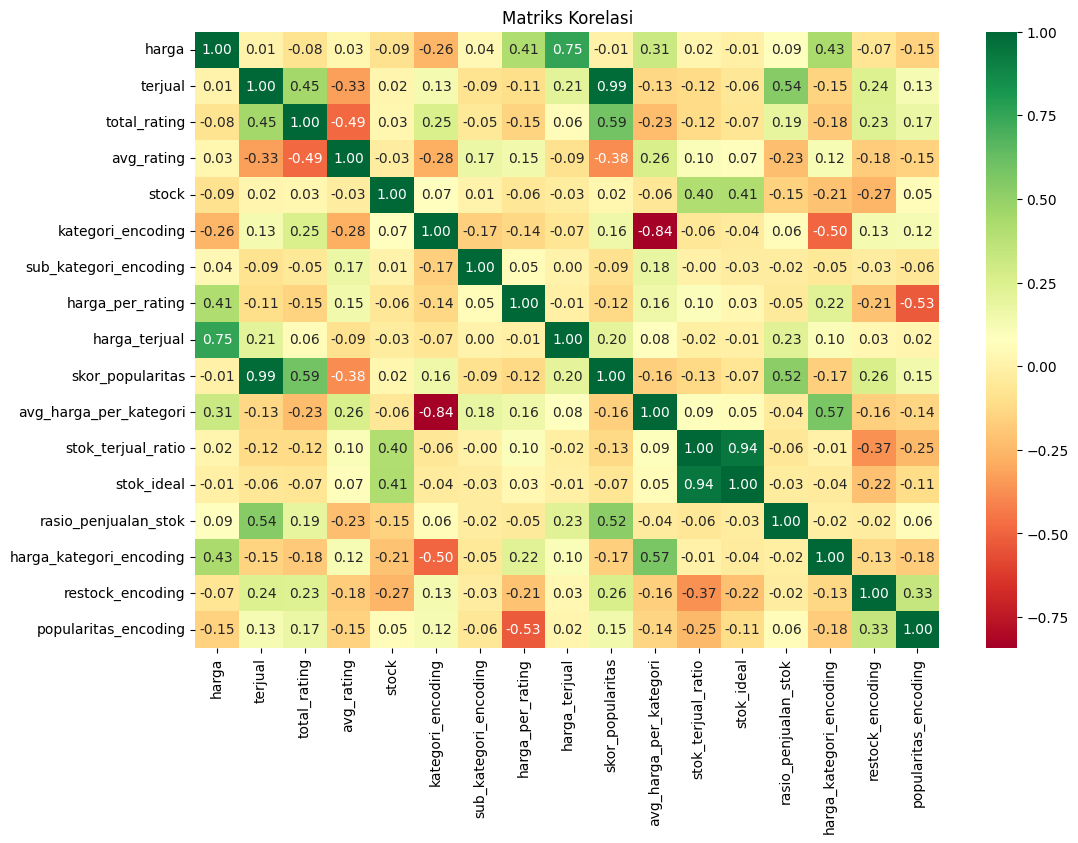

In [20]:
#Korelasi antar atribut
df_numeric = df.select_dtypes(include=['number'])
correlation_matrix = df_numeric.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn')
plt.title('Matriks Korelasi')
plt.show()

In [21]:
#Simpan CSV Atribut Extend
df.to_csv('data-final-project-cleaned-atribut-extend.csv', index=False)

In [22]:
df = pd.read_csv('data-final-project-cleaned-atribut-extend.csv')

In [23]:
#Skenario Perbandingan Model

dfDPM = df.drop(columns=['nama_produk', 'desc', 'store', 'kategori', 'sub_kategori', 'harga_kategori'], errors='ignore')
X = dfDPM[['avg_harga_per_kategori', 'harga_per_rating', 'harga_terjual']]
y = dfDPM['harga_kategori_encoding']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_modelPrice = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=4, max_features='sqrt', min_samples_split=5, min_samples_leaf=5, n_estimators=300)
rf_modelPrice.fit(X_train, y_train)

lr_modelPrice = LogisticRegression(C=1, max_iter=1000, penalty='l2', solver='lbfgs')
lr_modelPrice.fit(X_train, y_train)

svm_modelPrice = SVC()
svm_modelPrice.fit(X_train, y_train)

knn_modelPrice = KNeighborsClassifier(n_neighbors=15, p=2, weights='uniform')
knn_modelPrice.fit(X_train, y_train)

xgb_modelPrice = XGBClassifier(objective='multi:softprob', learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8, colsample_bytree=0.8)
xgb_modelPrice.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [24]:
#Clasification Report Testing and Training Evaluation
models = {'Random Forest': rf_modelPrice, 'Logistic Regression': lr_modelPrice, 'SVM': svm_modelPrice, 'KNN': knn_modelPrice, 'XGBoost': xgb_modelPrice}

for model_name, model in models.items():
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    print(f"{model_name} - Training Data Evaluation:")
    print(classification_report(y_train, y_train_pred, zero_division=1))

    print(f"{model_name} - Testing Data Evaluation:")
    print(classification_report(y_test, y_test_pred, zero_division=1))

Random Forest - Training Data Evaluation:
              precision    recall  f1-score   support

           0       0.82      0.96      0.89       255
           1       0.80      0.59      0.68       148
           2       0.95      0.94      0.94       216

    accuracy                           0.86       619
   macro avg       0.86      0.83      0.84       619
weighted avg       0.86      0.86      0.86       619

Random Forest - Testing Data Evaluation:
              precision    recall  f1-score   support

           0       0.78      0.92      0.84       109
           1       0.67      0.53      0.59        62
           2       0.95      0.88      0.92        95

    accuracy                           0.82       266
   macro avg       0.80      0.78      0.78       266
weighted avg       0.82      0.82      0.81       266

Logistic Regression - Training Data Evaluation:
              precision    recall  f1-score   support

           0       0.72      0.60      0.65       25

In [25]:
#Cross Validation Evaluation
for model_name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f'{model_name} - Cross-validation scores: {cv_scores}')
    print(f'{model_name} - Mean CV score: {np.mean(cv_scores)}\n')

Random Forest - Cross-validation scores: [0.79032258 0.7983871  0.84677419 0.86290323 0.82926829]
Random Forest - Mean CV score: 0.8255310778914241

Logistic Regression - Cross-validation scores: [0.58064516 0.57258065 0.5483871  0.58064516 0.56910569]
Logistic Regression - Mean CV score: 0.570272751114608

SVM - Cross-validation scores: [0.47580645 0.4516129  0.46774194 0.5483871  0.50406504]
SVM - Mean CV score: 0.4895226855494362

KNN - Cross-validation scores: [0.53225806 0.61290323 0.60483871 0.58870968 0.56910569]
KNN - Mean CV score: 0.5815630736952532

XGBoost - Cross-validation scores: [0.82258065 0.85483871 0.87096774 0.86290323 0.85365854]
XGBoost - Mean CV score: 0.8529897718332021



In [26]:
#Confusion Matrix Evaluation
predictions = pd.DataFrame({
    'Actual': y_test,
    'Random Forest': rf_modelPrice.predict(X_test),
    'Logistic Regression': lr_modelPrice.predict(X_test),
    'SVM': svm_modelPrice.predict(X_test),
    'KNN': knn_modelPrice.predict(X_test),
    'XGBoost': xgb_modelPrice.predict(X_test)
})

for model_name in models.keys():
    print(f"Crosstab for {model_name}:")
    crosstab = pd.crosstab(predictions['Actual'], predictions[model_name], margins=True)
    print(crosstab)
    print("\n")

Crosstab for Random Forest:
Random Forest    0   1   2  All
Actual                         
0              100   9   0  109
1               25  33   4   62
2                4   7  84   95
All            129  49  88  266


Crosstab for Logistic Regression:
Logistic Regression   0    2  All
Actual                           
0                    72   37  109
1                    19   43   62
2                     6   89   95
All                  97  169  266


Crosstab for SVM:
SVM       0   2  All
Actual              
0       109   0  109
1        62   0   62
2        79  16   95
All     250  16  266


Crosstab for KNN:
KNN       0   1   2  All
Actual                  
0        89   6  14  109
1        32  12  18   62
2        23  15  57   95
All     144  33  89  266


Crosstab for XGBoost:
XGBoost    0   1   2  All
Actual                   
0        100   9   0  109
1         14  43   5   62
2          2   8  85   95
All      116  60  90  266




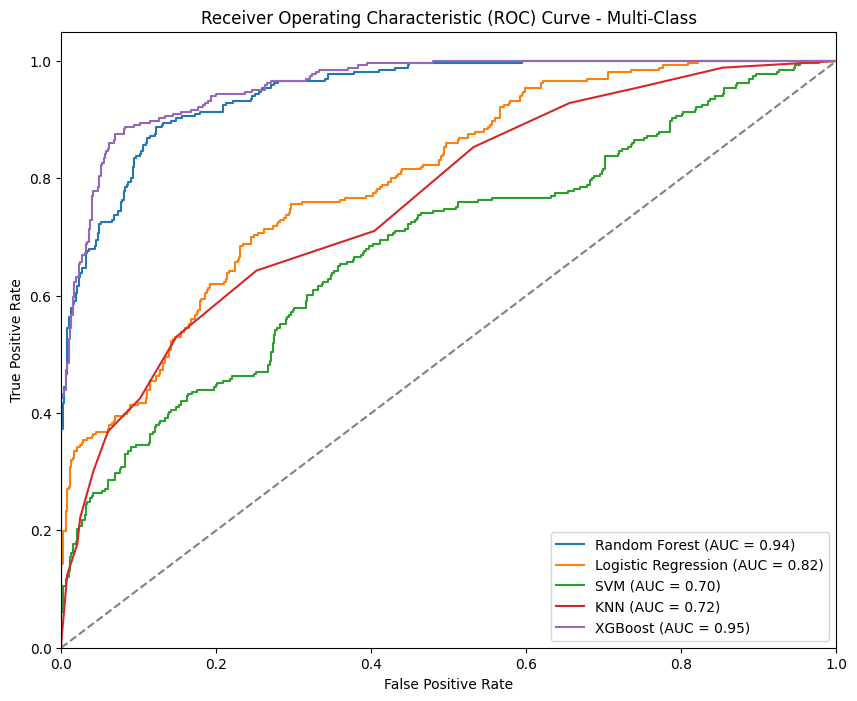

In [27]:
#ROC AUC Evaluation
y_train_bin = label_binarize(y_train, classes=[0, 1, 2])
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

plt.figure(figsize=(10, 8))

for model_name, model in models.items():
    model.fit(X_train, y_train)

    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)
    else:
        y_prob = model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
    auc_score = roc_auc_score(y_test_bin, y_prob, multi_class='ovr')

    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Multi-Class')
plt.legend(loc='lower right')
plt.show()

In [28]:
#Skenario Perbandingan Model

dfDPM = df.drop(columns=['nama_produk', 'desc', 'store', 'kategori', 'sub_kategori', 'harga_kategori', 'restock', 'popularitas'], errors='ignore')
X = dfDPM[['stok_ideal','stok_terjual_ratio', 'rasio_penjualan_stok']]
y = dfDPM['restock_encoding']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampleds, y_train_resampleds = smote.fit_resample(X_train, y_train)

undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_resampleds, y_train_resampleds)

rf_modelStock = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=4, max_features='sqrt', min_samples_split=5, min_samples_leaf=5, n_estimators=300)
rf_modelStock.fit(X_train_resampled, y_train_resampled)

lr_modelStock = LogisticRegression(C=1, max_iter=1000, penalty='l2', solver='lbfgs')
lr_modelStock.fit(X_train_resampled, y_train_resampled)

svm_modelStock = SVC()
svm_modelStock.fit(X_train_resampled, y_train_resampled)

knn_modelStock = KNeighborsClassifier(n_neighbors=15, p=2, weights='uniform')
knn_modelStock.fit(X_train_resampled, y_train_resampled)

xgb_modelStock = XGBClassifier(objective='multi:softprob', learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8, colsample_bytree=0.8)
xgb_modelStock.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [29]:
#Clasification Report Testing and Training Evaluation
models = {'Random Forest': rf_modelStock, 'Logistic Regression': lr_modelStock, 'SVM': svm_modelStock, 'KNN': knn_modelStock, 'XGBoost': xgb_modelStock}

for model_name, model in models.items():
    y_train_pred = model.predict(X_train_resampled)
    y_test_pred = model.predict(X_test)

    print(f"{model_name} - Training Data Evaluation:")
    print(classification_report(y_train_resampled, y_train_pred, zero_division=1))

    print(f"{model_name} - Testing Data Evaluation:")
    print(classification_report(y_test, y_test_pred, zero_division=1))

Random Forest - Training Data Evaluation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       436
           1       0.87      0.77      0.81       436
           2       0.79      0.88      0.83       436

    accuracy                           0.88      1308
   macro avg       0.89      0.88      0.88      1308
weighted avg       0.89      0.88      0.88      1308

Random Forest - Testing Data Evaluation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       0.42      0.61      0.50        31
           2       0.93      0.86      0.90       190

    accuracy                           0.86       266
   macro avg       0.78      0.83      0.80       266
weighted avg       0.88      0.86      0.87       266

Logistic Regression - Training Data Evaluation:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       43

In [30]:
#Cross Validation Evaluation
for model_name, model in models.items():
    cv_scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
    print(f'{model_name} - Cross-validation scores: {cv_scores}')
    print(f'{model_name} - Mean CV score: {np.mean(cv_scores)}\n')

Random Forest - Cross-validation scores: [0.8740458  0.8778626  0.90458015 0.85823755 0.91954023]
Random Forest - Mean CV score: 0.8868532654792197

Logistic Regression - Cross-validation scores: [0.7480916  0.78244275 0.82824427 0.8045977  0.78927203]
Logistic Regression - Mean CV score: 0.7905296715509931

SVM - Cross-validation scores: [0.54961832 0.60305344 0.54580153 0.56321839 0.58237548]
SVM - Mean CV score: 0.5688134304349097

KNN - Cross-validation scores: [0.77099237 0.82061069 0.83587786 0.76628352 0.77777778]
KNN - Mean CV score: 0.7943084437425053

XGBoost - Cross-validation scores: [0.89694656 0.90458015 0.96183206 0.90421456 0.9348659 ]
XGBoost - Mean CV score: 0.9204878476792139



In [31]:
#Confusion Matrix Evaluation
predictions = pd.DataFrame({
    'Actual': y_test,
    'Random Forest': rf_modelStock.predict(X_test),
    'Logistic Regression': lr_modelStock.predict(X_test),
    'SVM': svm_modelStock.predict(X_test),
    'KNN': knn_modelStock.predict(X_test),
    'XGBoost': xgb_modelStock.predict(X_test)
})

for model_name in models.keys():
    print(f"Crosstab for {model_name}:")
    crosstab = pd.crosstab(predictions['Actual'], predictions[model_name], margins=True)
    print(crosstab)
    print("\n")

Crosstab for Random Forest:
Random Forest   0   1    2  All
Actual                         
0              45   0    0   45
1               0  19   12   31
2               0  26  164  190
All            45  45  176  266


Crosstab for Logistic Regression:
Logistic Regression   0   1    2  All
Actual                               
0                    44   1    0   45
1                     0  14   17   31
2                     0  21  169  190
All                  44  36  186  266


Crosstab for SVM:
SVM      0   1    2  All
Actual                  
0       29   0   16   45
1        0   6   25   31
2        7   6  177  190
All     36  12  218  266


Crosstab for KNN:
KNN      0   1    2  All
Actual                  
0       44   0    1   45
1        2  18   11   31
2       23  39  128  190
All     69  57  140  266


Crosstab for XGBoost:
XGBoost   0   1    2  All
Actual                   
0        45   0    0   45
1         0  23    8   31
2         0  29  161  190
All      45  52  169  

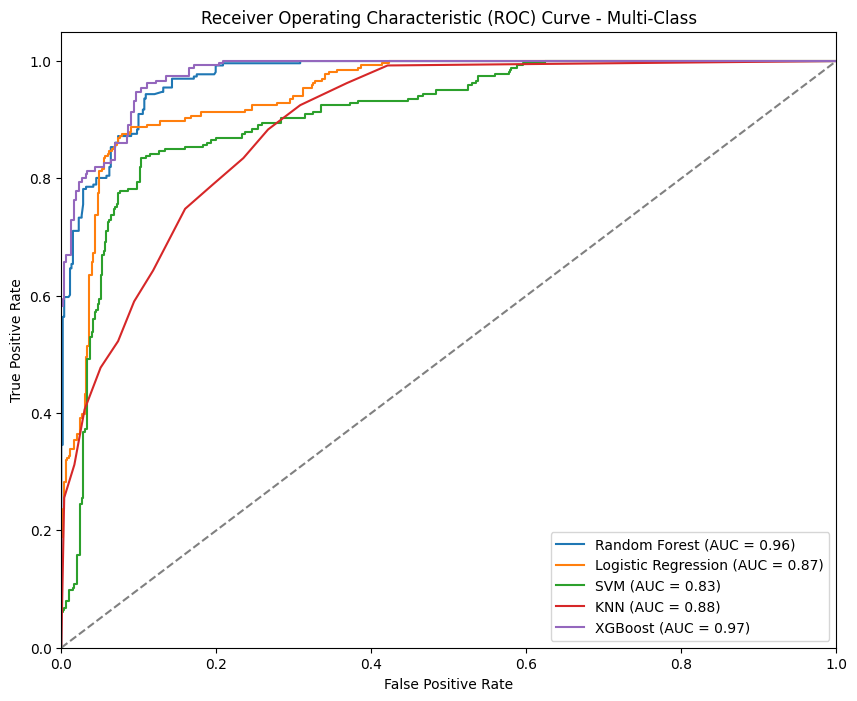

In [32]:
#ROC AUC Evaluation
y_train_bin = label_binarize(y_train_resampled, classes=[0, 1, 2])
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

plt.figure(figsize=(10, 8))

for model_name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)

    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)
    else:
        y_prob = model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
    auc_score = roc_auc_score(y_test_bin, y_prob, multi_class='ovr')

    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Multi-Class')
plt.legend(loc='lower right')
plt.show()

In [33]:
#Skenario Perbandingan Model

dfDPM = df.drop(columns=['nama_produk', 'desc', 'store', 'kategori', 'sub_kategori', 'harga_kategori', 'restock', 'popularitas'], errors='ignore')
X = dfDPM[['harga_per_rating', 'rasio_penjualan_stok', 'total_rating']]
#X = dfDPM.drop(columns=['popularitas_encoding'])
y = dfDPM['popularitas_encoding']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampleds, y_train_resampleds = smote.fit_resample(X_train, y_train)

undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_resampleds, y_train_resampleds)

rf_modelPopu = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=4, max_features='sqrt', min_samples_split=5, min_samples_leaf=5, n_estimators=300)
rf_modelPopu.fit(X_train_resampled, y_train_resampled)

lr_modelPopu = LogisticRegression(C=1, max_iter=1000, penalty='l2', solver='lbfgs')
lr_modelPopu.fit(X_train_resampled, y_train_resampled)

svm_modelPopu = SVC()
svm_modelPopu.fit(X_train_resampled, y_train_resampled)

knn_modelPopu = KNeighborsClassifier(n_neighbors=15, p=2, weights='uniform')
knn_modelPopu.fit(X_train_resampled, y_train_resampled)

xgb_modelPopu = XGBClassifier(objective='multi:softprob', learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8, colsample_bytree=0.8)
xgb_modelPopu.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [34]:
#Clasification Report Testing and Training Evaluation
models = {'Random Forest': rf_modelPopu, 'Logistic Regression': lr_modelPopu, 'SVM': svm_modelPopu, 'KNN': knn_modelPopu, 'XGBoost': xgb_modelPopu}

for model_name, model in models.items():
    y_train_pred = model.predict(X_train_resampled)
    y_test_pred = model.predict(X_test)

    print(f"{model_name} - Training Data Evaluation:")
    print(classification_report(y_train_resampled, y_train_pred, zero_division=1))

    print(f"{model_name} - Testing Data Evaluation:")
    print(classification_report(y_test, y_test_pred, zero_division=1))

Random Forest - Training Data Evaluation:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       585
           1       0.95      0.90      0.92       585
           2       1.00      0.98      0.99       585

    accuracy                           0.95      1755
   macro avg       0.95      0.95      0.95      1755
weighted avg       0.95      0.95      0.95      1755

Random Forest - Testing Data Evaluation:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         6
           1       0.50      0.67      0.57         3
           2       1.00      0.99      0.99       257

    accuracy                           0.98       266
   macro avg       0.75      0.88      0.81       266
weighted avg       0.99      0.98      0.99       266

Logistic Regression - Training Data Evaluation:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       58

In [35]:
#Cross Validation Evaluation
for model_name, model in models.items():
    cv_scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
    print(f'{model_name} - Cross-validation scores: {cv_scores}')
    print(f'{model_name} - Mean CV score: {np.mean(cv_scores)}\n')

Random Forest - Cross-validation scores: [0.93732194 0.95726496 0.93162393 0.95156695 0.94017094]
Random Forest - Mean CV score: 0.9435897435897436

Logistic Regression - Cross-validation scores: [0.94017094 0.94871795 0.94586895 0.94301994 0.95441595]
Logistic Regression - Mean CV score: 0.9464387464387464

SVM - Cross-validation scores: [0.62962963 0.65242165 0.60968661 0.62962963 0.61823362]
SVM - Mean CV score: 0.6279202279202278

KNN - Cross-validation scores: [0.74928775 0.75213675 0.72934473 0.71509972 0.7037037 ]
KNN - Mean CV score: 0.7299145299145299

XGBoost - Cross-validation scores: [0.95726496 0.96866097 0.94017094 0.97435897 0.95726496]
XGBoost - Mean CV score: 0.9595441595441596



In [36]:
#Confusion Matrix Evaluation
predictions = pd.DataFrame({
    'Actual': y_test,
    'Random Forest': rf_modelPopu.predict(X_test),
    'Logistic Regression': lr_modelPopu.predict(X_test),
    'SVM': svm_modelPopu.predict(X_test),
    'KNN': knn_modelPopu.predict(X_test),
    'XGBoost': xgb_modelPopu.predict(X_test)
})

for model_name in models.keys():
    print(f"Crosstab for {model_name}:")
    crosstab = pd.crosstab(predictions['Actual'], predictions[model_name], margins=True)
    print(crosstab)
    print("\n")

Crosstab for Random Forest:
Random Forest  0  1    2  All
Actual                       
0              6  0    0    6
1              1  2    0    3
2              1  2  254  257
All            8  4  254  266


Crosstab for Logistic Regression:
Logistic Regression   0  1    2  All
Actual                              
0                     6  0    0    6
1                     2  1    0    3
2                     2  5  250  257
All                  10  6  250  266


Crosstab for SVM:
SVM     0   1    2  All
Actual                 
0       2   3    1    6
1       1   2    0    3
2       1  15  241  257
All     4  20  242  266


Crosstab for KNN:
KNN      0   1    2  All
Actual                  
0        4   2    0    6
1        1   2    0    3
2       12  46  199  257
All     17  50  199  266


Crosstab for XGBoost:
XGBoost   0  1    2  All
Actual                  
0         6  0    0    6
1         2  0    1    3
2         2  1  254  257
All      10  1  255  266




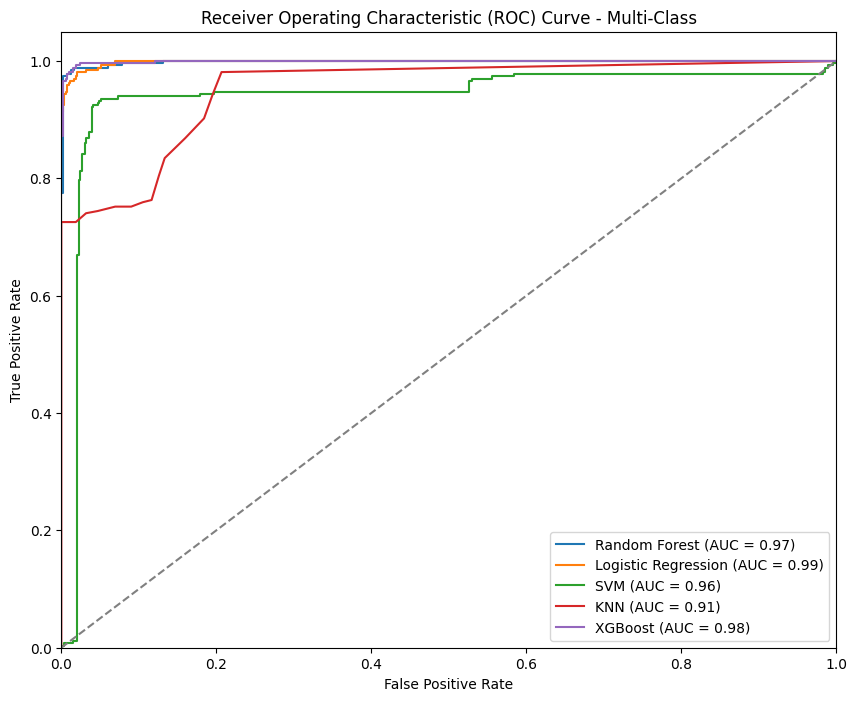

In [37]:
#ROC AUC Evaluation
y_train_bin = label_binarize(y_train_resampled, classes=[0, 1, 2])
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

plt.figure(figsize=(10, 8))

for model_name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)

    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)
    else:
        y_prob = model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
    auc_score = roc_auc_score(y_test_bin, y_prob, multi_class='ovr')

    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Multi-Class')
plt.legend(loc='lower right')
plt.show()

Rekomendasi Fitur Berdasarkan Pentingnya:
                    Feature  Importance
9          skor_popularitas    0.445860
1                   terjual    0.219575
2              total_rating    0.121369
7          harga_per_rating    0.069297
13     rasio_penjualan_stok    0.035620
11       stok_terjual_ratio    0.023883
8             harga_terjual    0.015433
0                     harga    0.014122
6     sub_kategori_encoding    0.012037
12               stok_ideal    0.010393
3                avg_rating    0.009692
4                     stock    0.008353
15         restock_encoding    0.007451
10   avg_harga_per_kategori    0.004004
5         kategori_encoding    0.002580
14  harga_kategori_encoding    0.000330


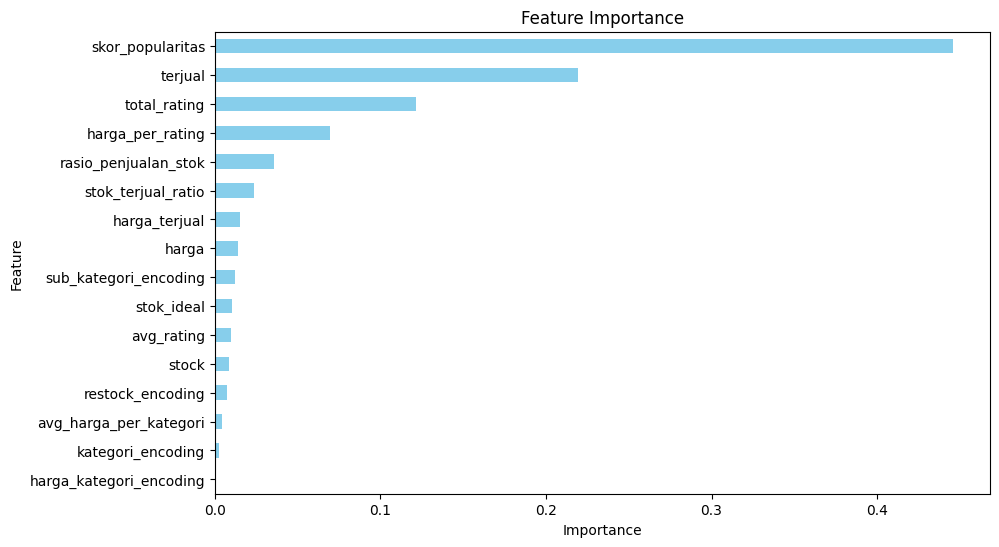

In [38]:
X = dfDPM.drop(columns=['popularitas_encoding'])
y = dfDPM['popularitas_encoding']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

feature_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Rekomendasi Fitur Berdasarkan Pentingnya:")
print(feature_df)

feature_df.plot.barh(x='Feature', y='Importance', color='skyblue', figsize=(10, 6), legend=False)
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [39]:
correlation_matrix = dfDPM.corr()

print(correlation_matrix['popularitas_encoding'].sort_values(ascending=False))

popularitas_encoding       1.000000
restock_encoding           0.331376
total_rating               0.171759
skor_popularitas           0.149044
terjual                    0.129415
kategori_encoding          0.123680
rasio_penjualan_stok       0.064104
stock                      0.054884
harga_terjual              0.019841
sub_kategori_encoding     -0.064213
stok_ideal                -0.112149
avg_harga_per_kategori    -0.137453
avg_rating                -0.151717
harga                     -0.154972
harga_kategori_encoding   -0.175057
stok_terjual_ratio        -0.247889
harga_per_rating          -0.527292
Name: popularitas_encoding, dtype: float64


In [40]:
#Model digunakan dipilih
rf_modelPrice #Menentukan harga dinamis
rf_modelStock #Menentukan stock ideal
xgb_modelPopu #Menentukan popularitas produk

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [44]:
#Eksport Model
import pickle

model1 = 'rf_modelPrice.sav'
pickle.dump(rf_modelPrice,open(model1,'wb'))

In [45]:
#Eksport Model
import pickle

model2 = 'rf_modelStock.sav'
pickle.dump(rf_modelStock,open(model2,'wb'))

In [46]:
#Eksport Model
import pickle

model3 = 'rf_modelPopu.sav'
pickle.dump(rf_modelPopu,open(model3,'wb'))

In [47]:
import pickle
import pandas as pd
import numpy as np

model1 = pickle.load(open('rf_modelPrice.sav', 'rb'))
model2 = pickle.load(open('rf_modelStock.sav', 'rb'))
model3 = pickle.load(open('rf_modelPopu.sav', 'rb'))

# Data utama
data_utama = {
    'nama_produk': ['Produk A', 'Produk B', 'Produk C', 'Produk D'],
    'kategori': [1, 2, 1, 5],
    'harga': [4334431, 50000, 80000, 35000],
    'total_rating': [1, 50, 300, 20],
    'terjual': [2, 20, 150, 5],
    'stock': [9990, 30, 5, 500]
}

df = pd.DataFrame(data_utama)

# Menambah kolom fitur
df['avg_harga_per_kategori'] = df.groupby('kategori')['harga'].transform('mean')
df['harga_per_rating'] = df['harga'] / (df['total_rating'] + 1)
df['harga_terjual'] = df['harga'] * df['terjual']
df['rasio_penjualan_stok'] = df['terjual'] / (df['stock'] + 1)
df['stok_terjual_ratio'] = df['stock'] / (df['terjual'] + 1)
df['stok_ideal'] = df['stok_terjual_ratio'] * df['stock']
df['stok_ideal'] = np.ceil(df['stok_ideal'])

# Prediksi menggunakan model
df['harga_kategori_encoding'] = rf_modelPrice.predict(df[['avg_harga_per_kategori', 'harga_per_rating', 'harga_terjual']])
df['restock_encoding'] = rf_modelStock.predict(df[['stok_ideal','stok_terjual_ratio', 'rasio_penjualan_stok']])
df['popularitas_encoding'] = rf_modelPopu.predict(df[['harga_per_rating', 'rasio_penjualan_stok', 'total_rating']])

# Mapping hasil prediksi ke kategori
harga_kategori_mapping = {0: 'Rendah', 1: 'Sedang', 2: 'Tinggi'}
restock_mapping = {1: 'Tidak Restock', 2: 'Restock', 0: 'Stok Berlebih'}
popularitas_mapping = {0: 'Tidak Populer', 1: 'Populer', 2: 'Sangat Populer'}

df['harga_kategori'] = df['harga_kategori_encoding'].map(harga_kategori_mapping)
df['restock'] = df['restock_encoding'].map(restock_mapping)
df['popularitas'] = df['popularitas_encoding'].map(popularitas_mapping)

# Kategori produk
categories = [
    'Elektronik', 'Lainnya', 'Perawatan Pribadi', 'Olahraga & Outdoor',
    'Peralatan Rumah Tangga', 'Pakaian & Fashion', 'Kendaraan & Aksesori',
    'Makanan & Minuman', 'Perhiasan & Aksesori', 'Mainan & Anak-Anak',
    'Gadget & Elektronik Musik'
]

# Fungsi prediksi
def prediction(df):
    df['avg_harga_per_kategori'] = df.groupby('kategori')['harga'].transform('mean')
    df['harga_per_rating'] = df['harga'] / (df['total_rating'] + 1)
    df['harga_terjual'] = df['harga'] * df['terjual']
    df['rasio_penjualan_stok'] = df['terjual'] / (df['stock'] + 1)
    df['stok_terjual_ratio'] = df['stock'] / (df['terjual'] + 1)
    df['stok_ideal'] = df['stok_terjual_ratio'] * df['stock']
    df['stok_ideal'] = np.ceil(df['stok_ideal'])

    df['harga_kategori_encoding'] = rf_modelPrice.predict(
        df[['avg_harga_per_kategori', 'harga_per_rating', 'harga_terjual']]
    )
    df['restock_encoding'] = rf_modelStock.predict(
        df[['stok_ideal', 'stok_terjual_ratio', 'rasio_penjualan_stok']]
    )
    df['popularitas_encoding'] = rf_modelPopu.predict(
        df[['harga_per_rating', 'rasio_penjualan_stok', 'total_rating']]
    )

    harga_kategori_mapping = {0: 'Rendah', 1: 'Sedang', 2: 'Tinggi'}
    restock_mapping = {1: 'Tidak Restock', 2: 'Restock', 0: 'Stok Berlebih'}
    popularitas_mapping = {0: 'Tidak Populer', 1: 'Populer', 2: 'Sangat Populer'}

    df['harga_kategori'] = df['harga_kategori_encoding'].map(harga_kategori_mapping)
    df['restock'] = df['restock_encoding'].map(restock_mapping)
    df['popularitas'] = df['popularitas_encoding'].map(popularitas_mapping)

# Fungsi rekomendasi
def rekomendasi(row):
    if row['restock'] == 'Restock':
        return "Segera lakukan restock produk ini."
    elif row['harga_kategori'] == 'Tinggi' and row['popularitas'] == 'Sangat Populer':
        return "Lakukan promosi pada produk populer ini."
    elif row['restock'] == 'Tidak Restock' and row['harga_kategori'] == 'Rendah':
        return "Evaluasi produk untuk diskon atau hapus dari katalog."
    elif row['popularitas'] == 'Tidak Populer' and row['restock'] == 'Stok Berlebih':
        return "Tunda restock produk ini dan evaluasi penjualannya."
    elif row['popularitas'] == 'Populer' and row['harga_kategori'] == 'Sedang':
        return "Pertahankan produk dengan harga dan popularitas saat ini."
    else:
        return "Pertahankan strategi saat ini."

df['Rekomendasi'] = df.apply(rekomendasi, axis=1)

# Hasil
df[['nama_produk', 'harga_kategori', 'restock', 'popularitas', 'Rekomendasi']]

,nama_produk,harga_kategori,restock,popularitas,Rekomendasi
0,Produk A,Tinggi,Stok Berlebih,Tidak Populer,Tunda restock produk ini dan evaluasi penjuala...
1,Produk B,Rendah,Stok Berlebih,Sangat Populer,Pertahankan strategi saat ini.
2,Produk C,Rendah,Restock,Sangat Populer,Segera lakukan restock produk ini.
3,Produk D,Rendah,Stok Berlebih,Sangat Populer,Pertahankan strategi saat ini.
